In the previous version of this notebook we generated DataFrames for each cell under one "genotype", where the data consisted of input R, series R, and peak EPSC amplitude per presynaptic stimulation under a voltage clamp protocol. However, the bulk of the data exists as intermingled experiments of either voltage or current clamp. Also, some of the individual folders that would correspond to a single cell are actually 2, since there were some simultaneous recordings saved as another abf.sweep'Y' channel (with another name probably). *This version will use the provided .csv files that contain the stimulus intensities as a metadata source for selecting between VClamp and IClamp analyses, skip over any errors in recordings, and detect and extract data from files where more than 1 cell was recorded.*

__I - Instalation of libraries and listing directories of data.__ -unchanged



In [3]:
pip install --upgrade pyabf

     |████████████████████████████████| 51kB 2.6MB/s eta 0:00:01
  Created wheel for pyabf: filename=pyabf-2.2.4-cp37-none-any.whl size=47354 sha256=ac705848dd562147cf77e4634d7cc9ac394d76752575b3438721229398969e8b
  Stored in directory: /Users/adrianalejandro/Library/Caches/pip/wheels/06/ff/20/d76d595be7f397375b438ea2c107d268a2b3ee07ed8a843106
Successfully built pyabf
  Found existing installation: pyabf 2.2.3
    Uninstalling pyabf-2.2.3:
      Successfully uninstalled pyabf-2.2.3
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pyabf
import pyabf.tools.memtest 
import matplotlib.pyplot as plt
import numpy as np
import os 
import os.path
from os import path
import csv
import pandas as pnd
from tkinter import Tk
from tkinter.filedialog import askdirectory

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/Users/adrianalejandro/opt/anaconda3/lib/python3.7/site-packages/pyabf/tools/__init__.py:8: UserWarning: All pyabf.tools modules are experimental (APIs may change)
  warnings.warn("All pyabf.tools modules are experimental (APIs may change)")


__II - Functions for obtaining csv metadata.__ -unchanged

In [5]:
def get_txt_metadata(mouse,contents):   
    all_header_files = []
    
    for filename in contents:
        if '.txt' not in filename and '.csv' not in filename and mouse not in filename: ###
            header_txt = filename + '_header.txt'
            header = open(header_txt,'w')
            all_header_files.append(header_txt)
            abf = pyabf.ABF(filename)
            header.write(abf.headerText)
            header.close()
    return(all_header_files)


In [6]:
def get_csv_metadata(all_header_files):
    
    csv_files = []

    for filename in all_header_files:
        if '.csv' not in filename and '.txt' in filename:
            header = open(filename,'r')
            metadata_str = []
    
            for line in header:
                if '=' in line:
                    metadata_str.append(line)
            
            csv_filename = filename.replace('.txt','.csv')
            metadata_csv = pnd.DataFrame(metadata_str)
        
            metadata_csv.columns = ['Data'] # pandas doesn't like column names to be 0 
            metadata_csv[['Data','Values']] = metadata_csv.Data.str.split(" = ",expand=True) # remove whitespaces too!!!
            metadata_csv.to_csv(csv_filename, sep=',',index=False)
            csv_files.append(csv_filename)
        
    return csv_files


__III - Functions for calculating resistance and peak amplitude values.__

Pertinent changes: 

1. Functions like `get_peak_pA` are modified to account for missing abf steps or simultaneous recordings.
2. Functions for IClamp analysis like `get_Hz`, `get_d_pA'`,`get_AP_width`. We will need to determine beforehand exactly which measures we wish to extract, but the format for these functions should be the same as what was used to get resistances in Vclamp!

In [229]:
def get_metadata_values(validated_csv,parameter):

    # Obtains raw data string associated to specified parameter in metadata.
    csv_metadata = pnd.read_csv(validated_csv)
    dic_metadata = csv_metadata.set_index('Data').to_dict()['Values'] # totally stolen from stack overflow and its FAST
    raw_str = dic_metadata[parameter] 
    return raw_str

def get_mV_step_interval(raw_str):
    # assumes only a single voltage step in voltage clamp experiments
    parsed_str = raw_str.split(', ')
    parsed_total = (len(parsed_str))
    for i in range(parsed_total):
        if '0.00' not in parsed_str[i]:
            # also stolen: this extracts string inside []
            values = parsed_str[i][parsed_str[i].find("[")+1:parsed_str[i].find("]")]
    step_points = (values.split(':'))
    step_start, step_end = int(step_points[0]), int(step_points[1])
    return step_start, step_end


In [8]:
def get_resistances(step_start, step_end, abf):
    Rs = []
    Ri = []
    for i in abf.sweepList:
        abf.setSweep(i)
        neg_maxI = min(abf.sweepY[step_start:step_end]) # channel = cell_number, 
        SeriesR = (abf.sweepC[step_start + 10]/neg_maxI) * 1000 #convert from gigaohms to megaohms
        Rs.append(SeriesR)
        Input_I = abf.sweepY[step_end - 10]
        InputR = ((abf.sweepC[step_end -10])/Input_I) * 1000 # change to real delta Vm
        Ri.append(InputR) 
    return Ri, Rs 

In [9]:
def get_RiRs_persweep(csv_file,abf):
    parameter = 'sweepEpochs' # This can be switched around if you want to use this function as a template for
                              # functions to call other parameters
    values = get_metadata_values(csv_file,parameter)    
    step_start, step_end = get_mV_step_interval(values)
    Ri, Rs = get_resistances(step_start, step_end, abf)
    return Ri, Rs

In [27]:
def get_peak_pA(abf,csv_file):  # and timepoints!
    
    parameter = 'dataRate' # tickrate
    peak_pA = []
    peak_pA_ind = []
    peak_pA_s = []
    latency_s = []
    pre_window_s = 0.005 # seconds to look at after artifact to find real starting point for EPSC, 100 ticks
    post_window_s = 0.01 # seconds to look after the real starting point to find EPSC peak, 200 ticks
    i1, i2 = 0, 5000 # first set of wide indices
    
    for i in abf.sweepList:
        
        tickrate = float(get_metadata_values(csv_file,parameter))
        abf.setSweep(i)
        
        pre_window_ticks = tickrate*pre_window_s 
        post_window_ticks = tickrate*post_window_s
    
        pos_max_ind = np.argmax(abf.sweepY[i1:i2]) # huge positive artifact

        #Fake calculations to show how numbers are managed with each sum operation
        pre_window_i1 = pos_max_ind + 2
        pre_window_i2 = int(pre_window_i1 + pre_window_ticks)
        # 3100 + 2 = 3102
        # 31200 + 100 = 3202
    
        post_window_i1 = int(pre_window_i1 + (np.argmax(abf.sweepY[pre_window_i1:pre_window_i2])))
        post_window_i2 = int(post_window_i1 + post_window_ticks)
        #3102 + 25 = 3127
        #3127 + 200 = 3327

        peak = min(abf.sweepY[post_window_i1:post_window_i2])
        peak_ind = int(post_window_i1 + (np.argmin(abf.sweepY[post_window_i1:post_window_i2])))
        peak_s = peak_ind/tickrate
        latency = peak_s - (pos_max_ind/tickrate) # peak time normalized to stimulus onset (huge positive current)
        #3127 + 10 = 3137 (index of peak pA)
        
        peak_pA.append(peak)       
        peak_pA_ind.append(peak_ind) 
        peak_pA_s.append(peak_s)
        latency_s.append(latency)
    
    return peak_pA, peak_pA_ind, peak_pA_s, latency_s

__IV - Functions for generating `DataFrame` with all measures above.__

`data_summary_percell` is changed to save 2 dataframes in case one folder includes 2 cells.

In [11]:
def df_prep(mouse,new_contents):
    abf_files = []
    csv_files = []

    for filename in new_contents:
        if '.txt' not in filename and '.csv' not in filename and mouse not in filename:
            abf_files.append(filename)
        elif '.csv' in filename and mouse not in filename:
            csv_files.append(filename) 
    abf_files.sort()
    csv_files.sort()
    abf_files.pop(0)
    csv_files.pop(0)
    return abf_files, csv_files


def get_stim_currents(mouse,contents): #stimulus currents file must be in csv format in the same folder as its abf's
    for file in contents:
        if mouse in file:
            segment_file = file
            current_steps = pnd.read_excel(segment_file)
            stim_int = current_steps['Stim Intensity (uA)'].tolist()
            stim_int = stim_int[1:-1] # some cleanup 
    return stim_int

def data_summary_percell(abf_files,csv_files,stim_int):
    mean_Ri = []
    mean_Rs = []
    mean_peak_pA = []
    all_peak_times = pnd.DataFrame()
    for i in range(len(abf_files)): #switch with validated ABF files
        abf = pyabf.ABF(abf_files[i]) 
        Ri, Rs = get_RiRs_persweep(csv_files[i],abf)
        # Get average resistances per file and save onto dataframe
        mean_Ri.append(np.mean(Ri))
        mean_Rs.append(np.mean(Rs))
    
        # Get peak amplitude of EPSC
        peak_pA, peak_pA_ind, peak_pA_s, latency_s = get_peak_pA(abf,csv_files)
        mean_peak_pA.append(np.mean(peak_pA))
        seg = abf_files[i].strip('.abf')
        segment = [seg for j in abf.sweepList]
        sweep_num = abf.sweepList
        peak_times = pnd.DataFrame(list(zip(peak_pA_ind,peak_pA_s,latency_s,segment)), index=sweep_num, columns =  
                          ["peak_pA_frame", "peak_pA_time_(s)","peak_latency_(s)","sweep_number"])
        all_peak_times = all_peak_times.append(peak_times,ignore_index=False)
    
    cell_df = pnd.DataFrame(list(zip(stim_int, mean_Ri, mean_Rs, mean_peak_pA)), index=abf_files, columns =  
                          ["stimulus_intensity_uA", "Input_Resistance_MOhm", "Series_Resistance_MOhm",
                           'Peak_amplitude_pA'])                       
    pivot_peak_times = all_peak_times.pivot(index=all_peak_times.index, columns='sweep_number') # Tidy the data by sweep number :)
    return cell_df , pivot_peak_times
    

In [12]:
# Master function that generates dataframes containing Rs, Rs, peak_pA and respective timepoints, for each cell

def summarize_cell_VClamp(mouse,cell_dir):
    
    os.chdir(cell_dir) # change directory to cell abf files
    if os.path.exists('.DS_Store') == True: # my own computer creates this given that i use a backup drive, 
        os.remove('.DS_Store')   
        
    contents = os.listdir('.') # list all contents in this cell folder
    all_header_files = get_txt_metadata(mouse,contents) 
    all_csv_files = get_csv_metadata(all_header_files)
    all_header_files.sort()
    all_csv_files.sort()
    new_contents = os.listdir('.')
    abf_files, csv_files = df_prep(mouse,new_contents) #ignore first sweeps that are just an equilibration
    #stim_int = get_stim_currents(mouse,new_contents)
    stim_int, cellnum = get_cellnum_and_stim(mouse,new_contents) #currently troubleshooting
    summary, all_peak_times = data_summary_percell(abf_files,csv_files,stim_int)
    
    return summary, all_peak_times
    

In [241]:

path = askdirectory(title='Select Folder with all data from one genotype') # shows dialog box and return the path 
os.chdir(path)

if os.path.exists('.DS_Store') == True: # my own computer creates this given that i use a backup drive, 
    os.remove('.DS_Store')          
gen_dir = os.getcwd()
mouse_folders = os.listdir('.')

for mouse in mouse_folders:    
    mouse_dir = gen_dir + '/' + mouse # get directory for one mouse
    os.chdir(mouse_dir)  #change directory to that mouse
    if os.path.exists('.DS_Store') == True: # my own computer creates this given that i use a backup drive, 
        os.remove('.DS_Store')    
    cwd = os.getcwd() 
    print(cwd)
    cell_folders = os.listdir(cwd) # list the cells (directories) of that mouse
    print(cell_folders) 
    for cell in cell_folders:
        
        os.chdir(mouse_dir)
        if cell == '.DS_Store':
            os.remove('.DS_Store')    
        elif 'cell' in cell and 'processed' not in cell:
            processed_file = cell + '_processed.csv'
            processed_dir = cwd + '/' + processed_file
            #os.mkdir(processed_dir)
            cell_dir = mouse_dir + '/' + cell
            summary, all_peak_times = summarize_cell_VClamp(mouse,cell_dir)
            
            summ_path = processed_dir + '/' + cell + '_summary.csv'
            tp_path = processed_dir + '/'  + cell + '_timepoints.csv'
            #summary.to_csv(summ_path, index = True)
            #all_peak_times.to_csv(tp_path, index = True)

/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953
['028953slice1cell1', '028953slice1cell2']
[]
[]
[]
[]
[]
[]
[]
['19d18009.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt', '19d18003.abf_header.txt']


['19d18009.abf_header.txt', '19d18008.abf_header.txt', '19d18003.abf_header.txt', '19d18002.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt', '19d18003.abf_header.txt', '19d18002.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt', '19d18003.abf_header.txt', '19d18002.abf_header.txt', '19d18000.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt', '19d18003.abf_header.txt', '19d18002.abf_header.txt', '19d18000.abf_header.txt', '19d18001.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt', '19d18003.abf_header.txt', '19d18002.abf_header.txt', '19d18000.abf_header.txt', '19d18001.abf_header.txt', '19d18005.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt', '19d18003.abf_header.txt', '19d18002.abf_header.txt', '19d18000.abf_header.txt', '19d18001.abf_header.txt', '19d18005.abf_header.txt']
['19d18009.abf_header.txt', '19d18008.abf_header.txt', '19d18003.abf_header.txt', '19d18002.abf_header.

['19d18018.abf_header.txt']
['19d18018.abf_header.txt', '19d18019.abf_header.txt']
['19d18018.abf_header.txt', '19d18019.abf_header.txt', '19d18017.abf_header.txt']
['19d18018.abf_header.txt', '19d18019.abf_header.txt', '19d18017.abf_header.txt', '19d18016.abf_header.txt']
['19d18018.abf_header.txt', '19d18019.abf_header.txt', '19d18017.abf_header.txt', '19d18016.abf_header.txt', '19d18014.abf_header.txt']
['19d18018.abf_header.txt', '19d18019.abf_header.txt', '19d18017.abf_header.txt', '19d18016.abf_header.txt', '19d18014.abf_header.txt', '19d18015.abf_header.txt']
['19d18018.abf_header.txt', '19d18019.abf_header.txt', '19d18017.abf_header.txt', '19d18016.abf_header.txt', '19d18014.abf_header.txt', '19d18015.abf_header.txt', '19d18011.abf_header.txt']
['19d18018.abf_header.txt', '19d18019.abf_header.txt', '19d18017.abf_header.txt', '19d18016.abf_header.txt', '19d18014.abf_header.txt', '19d18015.abf_header.txt', '19d18011.abf_header.txt', '19d18010.abf_header.txt']
['19d18018.abf_heade

__V - Troubleshooting and implementation of 1 or 2 cell conditionals in functions above__

 New functions - Detect if cell had wonky recordings, was actually 2 cells, and adjust indexing accordingly:
 
 1. open excel file and get value for entry under `cellnum` column. 
 2. Extract BOTH File column and Stimulus Intensity pA column as lists. 
 3. Sort so that files are in order of ascending stimulus intensity (use dictionary or just a table). Note: other functions can use the File column as a list to index through and thus a function input
 4. Rewrite other functions in the pipeline to fit this change

 

We start by writing a function that gets all of the important metadata from the excel files that are a transcript from lab notes on the experiment. The main things we obtain are the stimulus intensities, the number of cells recorded in that file (later will be selected as `channel`) and a list of validated ABF files that will be included in that cell's `DataFrame`. 

In [235]:
def get_xlxs_data(mouse,contents): 
    for file in contents:
        if mouse in file: #experimental notes file is the only one in each mouse folder with the name of that mouse
            segment_file = file
            exp_notes = pnd.read_excel(segment_file)
            stim_int = exp_notes['Stim Intensity (uA)'].tolist()
            stim_int.pop(0)
            cellnum = exp_notes['cellnum']
            cellnum = int(cellnum[0]) 
            validated_ABFs = exp_notes['File'].tolist()
            validated_ABFs.pop(0)
    return stim_int, cellnum, validated_ABFs

#This functions assumes that 1. stimulation currents are in ascending order along with their respective files and
#2. there is a "cellnum" column with only one row

In [224]:
#Specify! 
cell_dir = '/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell1'
mouse = '171219_SCH-028953'
#Get summary of everything
os.chdir(cell_dir) # change directory to cell abf files
if os.path.exists('.DS_Store') == True: # my own computer creates this given that i use a backup drive, 
        os.remove('.DS_Store')   
        
contents = os.listdir('.') # list all contents in this cell folder
all_header_files = get_txt_metadata(mouse,contents) 
all_csv_files = get_csv_metadata(all_header_files)
all_header_files.sort()
all_csv_files.sort()
new_contents = os.listdir('.')
abf_files, csv_files = df_prep(mouse,new_contents) #ignore first sweeps that are just an equilibration
stim_int, cellnum, validated_ABFs = get_xlxs_data(mouse,new_contents)
print(cellnum, stim_int, validated_ABFs)

1 [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75] ['19d18001.abf', '19d18002.abf', '19d18003.abf', '19d18004.abf', '19d18005.abf', '19d18006.abf', '19d18007.abf', '19d18008.abf', '19d18009.abf']


This next function replaces the original `df_prep` for a newer version that only lists the filenames of the csv's needed for the validated ABF files. 

In [232]:
#Find csv file that matches the name in "validated_ABFs"
def df_prep_v2(mouse,validated_ABFs,contents):
    validated_CSVs = []

    for filename in validated_ABFs:
        name = filename.replace('.abf','')
        for file in contents:        
            if  name in file and 'csv' in file:
                validated_CSVs.append(file)
    return validated_CSVs

In [226]:
#Replacing the df_prep function
#Specify! 
cell_dir = '/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell1'
mouse = '171219_SCH-028953'
#Get summary of everything
os.chdir(cell_dir) # change directory to cell abf files
if os.path.exists('.DS_Store') == True: # my own computer creates this given that i use a backup drive, 
        os.remove('.DS_Store')   
        
contents = os.listdir('.') # list all contents in this cell folder
all_header_files = get_txt_metadata(mouse,contents) 
all_csv_files = get_csv_metadata(all_header_files)
all_header_files.sort()
all_csv_files.sort()
new_contents = os.listdir('.')
#abf_files, csv_files = df_prep(mouse,new_contents) #ignore first sweeps that are just an equilibration
stim_int, cellnum, validated_ABFs = get_xlxs_data(mouse,contents)
validated_CSVs = df_prep_v2(mouse,validated_ABFs,contents)
print(cellnum, stim_int, validated_ABFs, validated_CSVs)


1 [0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75] ['19d18001.abf', '19d18002.abf', '19d18003.abf', '19d18004.abf', '19d18005.abf', '19d18006.abf', '19d18007.abf', '19d18008.abf', '19d18009.abf'] ['19d18001.abf_header.csv', '19d18002.abf_header.csv', '19d18003.abf_header.csv', '19d18004.abf_header.csv', '19d18005.abf_header.csv', '19d18006.abf_header.csv', '19d18007.abf_header.csv', '19d18008.abf_header.csv', '19d18009.abf_header.csv']


With these functions we can now run an instance of the `get_summary_per_cell` but with a twist: it will first check if there is more than one cell recorded in this experiment, and if so, it will run twice, once for `channel = cellnum` and another for `channel = cellnum + 2`, both arguments in `abf.setSweep()`. The syntax needed to access one or both channels is included below, along with some plotting that will be used down the line to generate figures for each cell as part of their data summary. 

In [227]:
# Get mean trace of sweeps from a single file
def get_mean_trace(abf,channel_ind):
    all_traces = []
    for i in abf.sweepList:
        abf.setSweep(i, channel=channel_ind)
        all_traces.append(abf.sweepY)
    mean_trace = np.mean(all_traces,axis=0)
    return mean_trace

In [139]:
#Outputs of this function are saved in each cell folder
def plot_mean_sweep_with_vline(file,cell_ind,i1,i2,lines):
    
    abf = pyabf.ABF(file)
    fig = plt.figure(figsize=(10, 5))
    cm = plt.get_cmap("viridis") #Make colormap to distinguish sweeps
    colors = [cm(x/len(lines)) for x in range(len(lines))]
    
    mean_trace = get_mean_trace(abf,1)
    abf.setSweep(1)
    #frame_axis = np.arange(abf.sweepPointCount)
    mean_trace = get_mean_trace(abf,channel_ind)
    #dataX = frame_axis[i1:i2]
    dataX = abf.sweepX[i1:i2]
    dataY = mean_trace[i1:i2]
    plt.plot(dataX,dataY,color='black')
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.title('Registered timepoints for peak amplitudes and mean trace of '+ file, 'cell ' + str(cell_ind))
    for i in abf.sweepList:
        plt.axvline(x=lines[i],color=colors[i],ymin =0.0, ymax=0.3,linestyle='--')         
    return fig

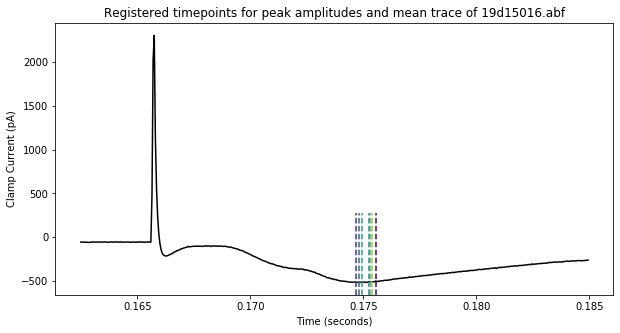

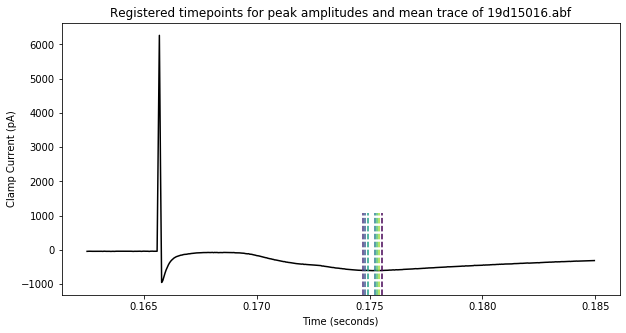

In [140]:
cell_dir = '/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/151219_SCH-029044/029044slice1cell2_3'
os.chdir(cell_dir)
mouse = '151219_SCH-029044'
contents = os.listdir('.') # list all contents in this cell folder
all_header_files = get_txt_metadata(mouse,contents) 
all_csv_files = get_csv_metadata(all_header_files)
all_header_files.sort()
all_csv_files.sort()
new_contents = os.listdir('.')
stim_int, cellnum, validated_ABFs = get_xlxs_data(mouse,contents)
validated_CSVs = df_prep_v2(mouse,validated_ABFs,new_contents)

abf = pyabf.ABF(validated_ABFs[5])
peak_pA, peak_pA_ind, peak_pA_s, latency_s = get_peak_pA(abf,validated_CSVs[5])


i1 = 3250
i2 = 3700
channel_ind = 0
file = '19d15016.abf'
fig = plot_mean_sweep_with_vline(file,cell_ind,i1,i2,peak_pA_s)

channel_ind = 2
fig = plot_mean_sweep_with_vline(file,cell_ind,i1,i2,peak_pA_s)

We now rewrite some of the functions from the other sections to fit the condition of the number of cells per file. We start by changing how the resistances are calculated, since we were using the command waveform rather than the actual recorded voltage of the cell. 

In [206]:
def get_resistances_v2(channel_ind,step_start, step_end, abf):
    Rs = []
    Ri = []
    for i in abf.sweepList:
        abf.setSweep(i, channel = channel_ind) # channel = cellnum 
        neg_maxI = min(abf.sweepY[step_start:step_end]) 
        Input_I = abf.sweepY[step_end - 10]
        neg_max_index = int(np.argmin(abf.sweepY[step_start:step_end]) + step_start)
        
        abf.setSweep(i,channel= channel_ind + 1)
        SeriesR = (abf.sweepY[neg_max_index]/neg_maxI) * 1000 #convert from gigaohms to megaohms
        Rs.append(SeriesR)
        
        InputR = ((abf.sweepY[step_end -10])/Input_I) * 1000 # change to real delta Vm
        Ri.append(InputR) 
        
    return Ri, Rs 

In [248]:
#Accesory for visualizing resistances from new function above
def plot_Rtest_v2(sweep_ind,abf,i1,i2):
    
    abf.setSweep(sweep_ind, channel = 0)
    frame_axis = range(abf.sweepPointCount)
    fig = plt.figure(figsize=(8, 4))
    
    ax1 = fig.add_subplot(211)
    ax1.set_title("Resistance test")
    ax1.plot(frame_axis[i1:i2], abf.sweepY[i1:i2])
    ax1.set_ylabel(abf.sweepLabelY)
    
    abf.setSweep(sweep_ind, channel = 1)
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.plot(frame_axis[i1:i2], abf.sweepY[i1:i2], color='r')
    ax2.set_xlabel('data_frames')
    ax2.set_ylabel(abf.sweepLabelY)

    return fig

[979.8245429992676, 1053.7736415863037, 955.1281929016113, 1228.0219793319702, 1140.3061151504517, 1024.311900138855, 1084.951400756836] [55.57221546769142, 55.54445460438728, 55.43369799852371, 55.932629853487015, 55.90452253818512, 55.406078696250916, 55.62499910593033]
[979.8245429992676, 1053.7736415863037, 955.1281929016113, 1228.0219793319702, 1140.3061151504517, 1024.311900138855, 1084.951400756836] [55.57221546769142, 55.54445460438728, 55.43369799852371, 55.932629853487015, 55.90452253818512, 55.406078696250916, 55.62499910593033]


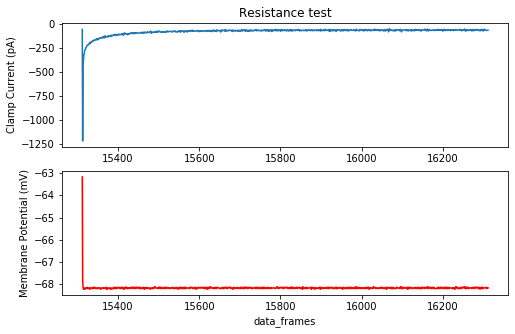

In [181]:
#Testing update function to get resistances
parameter = 'sweepEpochs'
csv = '19d15016.abf_header.csv'
raw_str = get_metadata_values(csv,parameter)
step_start, step_end = get_mV_step_interval(raw_str)
cellnum = 1
channel_ind = cellnum - 1

abf = pyabf.ABF('19d15016.abf')
Ri, Rs = get_resistances_v2(channel_ind, step_start, step_end, abf)
print(Ri, Rs)
Ri, Rs = get_resistances_v2(channel_ind, 15312, 16312, abf)
print(Ri, Rs)

Rtest_sample = plot_Rtest_v2(1,abf,step_start,step_end)

We see that the values make sense when comparing the first peak in the graph with V = IR. We update `get_RiRs_persweep` to accomodate these changes in indexing per cell number. 

In [208]:
def get_RiRs_persweep_v2(channel_ind,validated_csv,abf):
    parameter = 'sweepEpochs' # This can be switched around if you want to use this function as a template for
                              # functions to call other parameters
    values = get_metadata_values(validated_csv,parameter)    
    step_start, step_end = get_mV_step_interval(values)
    Ri, Rs = get_resistances_v2(channel_ind,step_start, step_end, abf)
    return Ri, Rs

`get_peak_pA`, which also gets the timepoints in each sweep, is also updated to account for this cell-number indexing. However, this is not yet the level in which we will apply any loops that perform different actions if the cell number is 1 or more, so it should look fairly similar to the previus version.

In [209]:
def get_peak_pA_v2(channel_ind,abf,validated_csv):  # and timepoints!
    
    parameter = 'dataRate' # tickrate
    peak_pA = []
    peak_pA_ind = []
    peak_pA_s = []
    latency_s = []
    pre_window_s = 0.005 # seconds to look at after artifact to find real starting point for EPSC, 100 ticks
    post_window_s = 0.01 # seconds to look after the real starting point to find EPSC peak, 200 ticks
    i1, i2 = 0, 5000 # first set of wide indices
    
    for i in abf.sweepList:
        
        tickrate = float(get_metadata_values(validated_csv,parameter))
        abf.setSweep(i, channel=channel_ind)
        
        pre_window_ticks = tickrate*pre_window_s 
        post_window_ticks = tickrate*post_window_s
    
        pos_max_ind = np.argmax(abf.sweepY[i1:i2]) # huge positive artifact

        #Fake calculations to show how numbers are managed with each sum operation
        pre_window_i1 = pos_max_ind + 2
        pre_window_i2 = int(pre_window_i1 + pre_window_ticks)
        # 3100 + 2 = 3102
        # 31200 + 100 = 3202
    
        post_window_i1 = int(pre_window_i1 + (np.argmax(abf.sweepY[pre_window_i1:pre_window_i2])))
        post_window_i2 = int(post_window_i1 + post_window_ticks)
        #3102 + 25 = 3127
        #3127 + 200 = 3327

        peak = min(abf.sweepY[post_window_i1:post_window_i2])
        peak_ind = int(post_window_i1 + (np.argmin(abf.sweepY[post_window_i1:post_window_i2])))
        peak_s = peak_ind/tickrate
        latency = peak_s - (pos_max_ind/tickrate) # peak time normalized to stimulus onset (huge positive current)
        #3127 + 10 = 3137 (index of peak pA)
        
        peak_pA.append(peak)       
        peak_pA_ind.append(peak_ind) 
        peak_pA_s.append(peak_s)
        latency_s.append(latency)
    
    return peak_pA, peak_pA_ind, peak_pA_s, latency_s

We then run an entire loop for obtaining a `DataFrame`s from a single file, which in this case consists of 2 cells rather than 1. The `cellnum` index would need to be used in essentially all of the main functions for creating the dataframe. 

In [246]:
def data_summary_percell_v2(channel_ind,validated_ABFs,validated_CSVs,stim_int):
    mean_Ri = []
    mean_Rs = []
    mean_peak_pA = []
    all_peak_times = pnd.DataFrame()
    for i in range(len(validated_ABFs)): #switch with validated ABF files
        abf = pyabf.ABF(validated_ABFs[i]) 
        Ri, Rs = get_RiRs_persweep_v2(channel_ind,validated_CSVs[i],abf)
        # Get average resistances per file and save onto dataframe
        mean_Ri.append(np.mean(Ri))
        mean_Rs.append(np.mean(Rs))
    
        # Get peak amplitude of EPSC
        peak_pA, peak_pA_ind, peak_pA_s, latency_s = get_peak_pA_v2(channel_ind,abf,validated_CSVs[i])
        mean_peak_pA.append(np.mean(peak_pA))
        seg = validated_ABFs[i].strip('.abf')
        segment = [seg for j in abf.sweepList]
        sweep_num = abf.sweepList
        peak_times = pnd.DataFrame(list(zip(peak_pA_ind,peak_pA_s,latency_s,segment)), index=sweep_num, columns =  
                          ["peak_pA_frame", "peak_pA_time_(s)","peak_latency_(s)","sweep_number"])
        all_peak_times = all_peak_times.append(peak_times,ignore_index=False)
        pivot_peak_times = all_peak_times.pivot(index=all_peak_times.index, columns='sweep_number') # Tidy the data by sweep number :)
        
        i1 = 3250 #arbitrary indices to choose limits on x axis of traces, can be changed to replace saved figures if run again
        i2 = 3700
        fig = plot_mean_sweep_with_vline(validated_ABFs[i],channel_ind,i1,i2,peak_pA_s)
        
    cell_df = pnd.DataFrame(list(zip(stim_int, mean_Ri, mean_Rs, mean_peak_pA)), index=validated_ABFs, columns =  
                          ["stimulus_intensity_uA", "Input_Resistance_MOhm", "Series_Resistance_MOhm",
                           'Peak_amplitude_pA'])                       
    
    return cell_df , pivot_peak_times, fig
    

/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/151219_SCH-029044/029044slice1cell2_3
['19d15011.abf', '19d15012.abf', '19d15013.abf', '19d15014.abf', '19d15015.abf', '19d15016.abf', '19d15017.abf', '19d15018.abf', '19d15019.abf']
['19d15011.abf_header.csv', '19d15012.abf_header.csv', '19d15013.abf_header.csv', '19d15014.abf_header.csv', '19d15015.abf_header.csv', '19d15016.abf_header.csv', '19d15017.abf_header.csv', '19d15018.abf_header.csv', '19d15019.abf_header.csv']
[0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
['19d15011.abf', '19d15012.abf', '19d15013.abf', '19d15014.abf', '19d15015.abf', '19d15016.abf', '19d15017.abf', '19d15018.abf', '19d15019.abf']
['19d15011.abf_header.csv', '19d15012.abf_header.csv', '19d15013.abf_header.csv', '19d15014.abf_header.csv', '19d15015.abf_header.csv', '19d15016.abf_header.csv', '19d15017.abf_header.csv', '19d15018.abf_header.csv', '19d15019.abf_header.csv']
[0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]


/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/151219_SCH-029044/029044slice1cell4_5


['19d15021.abf', '19d15022.abf', '19d15023.abf', '19d15024.abf', '19d15025.abf', '19d15026.abf', '19d15027.abf', '19d15028.abf', '19d15029.abf']
['19d15021.abf_header.csv', '19d15022.abf_header.csv', '19d15023.abf_header.csv', '19d15024.abf_header.csv', '19d15025.abf_header.csv', '19d15026.abf_header.csv', '19d15027.abf_header.csv', '19d15028.abf_header.csv', '19d15029.abf_header.csv']
[0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]


/Users/adrianalejandro/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


['19d15021.abf', '19d15022.abf', '19d15023.abf', '19d15024.abf', '19d15025.abf', '19d15026.abf', '19d15027.abf', '19d15028.abf', '19d15029.abf']
['19d15021.abf_header.csv', '19d15022.abf_header.csv', '19d15023.abf_header.csv', '19d15024.abf_header.csv', '19d15025.abf_header.csv', '19d15026.abf_header.csv', '19d15027.abf_header.csv', '19d15028.abf_header.csv', '19d15029.abf_header.csv']
[0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]


/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/151219_SCH-029044/029044slice1cell6
['19d15031.abf', '19d15032.abf', '19d15033.abf', '19d15034.abf', '19d15035.abf', '19d15036.abf', '19d15037.abf', '19d15038.abf', '19d15039.abf']
['19d15031.abf_header.csv', '19d15032.abf_header.csv', '19d15033.abf_header.csv', '19d15034.abf_header.csv', '19d15035.abf_header.csv', '19d15036.abf_header.csv', '19d15037.abf_header.csv', '19d15038.abf_header.csv', '19d15039.abf_header.csv']
[0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]


/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/151219_SCH-029044/029044slice1cell1
['19d15001.abf', '19d15002.abf', '19d15003.abf', '19d15004.abf', '19d15005.abf', '19d15006.abf', '19d15007.abf', '19d15008.abf', '19d15009.abf']
['19d15001.abf_header.csv', '19d15002.abf_header.csv', '19d15003.abf_header.csv', '19d15004.abf_header.csv', '19d15005.abf_header.csv', '19d15006.abf_header.csv', '19d15007.abf_header.csv', '19d15008.abf_header.csv', '19d15009.abf_header.csv']
[0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]


/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell1
['19d18001.abf', '19d18002.abf', '19d18003.abf', '19d18004.abf', '19d18005.abf', '19d18006.abf', '19d18007.abf', '19d18008.abf', '19d18009.abf']
['19d18001.abf_header.csv', '19d18002.abf_header.csv', '19d18003.abf_header.csv', '19d18004.abf_header.csv', '19d18005.abf_header.csv', '19d18006.abf_header.csv', '19d18007.abf_header.csv', '19d18008.abf_header.csv', '19d18009.abf_header.csv']
[0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]


/Users/adrianalejandro/Desktop/Gomez_rotation/sample data/171219_SCH-028953/028953slice1cell2
['19d18011.abf', '19d18012.abf', '19d18013.abf', '19d18014.abf', '19d18015.abf', '19d18016.abf', '19d18017.abf', '19d18018.abf', '19d18019.abf']
['19d18011.abf_header.csv', '19d18012.abf_header.csv', '19d18013.abf_header.csv', '19d18014.abf_header.csv', '19d18015.abf_header.csv', '19d18016.abf_header.csv', '19d18017.abf_header.csv', '19d18018.abf_header.csv', '19d18019.abf_header.csv']
[0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]


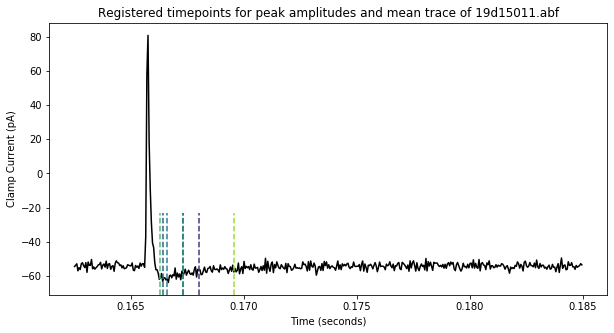

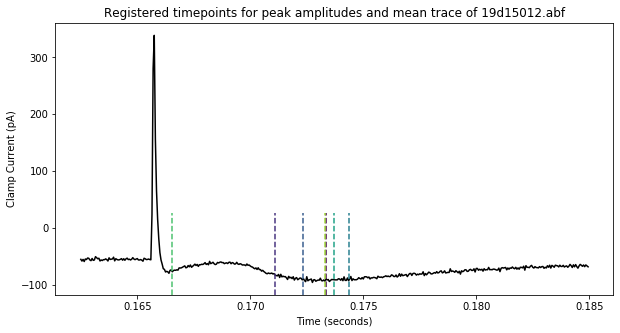

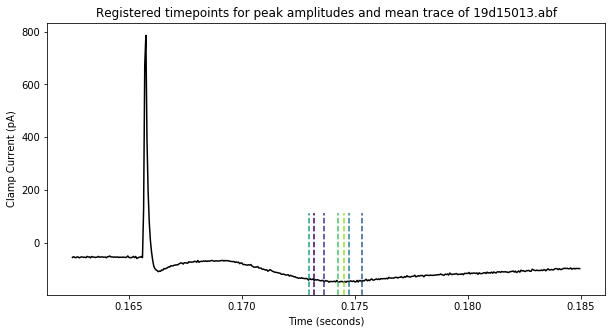

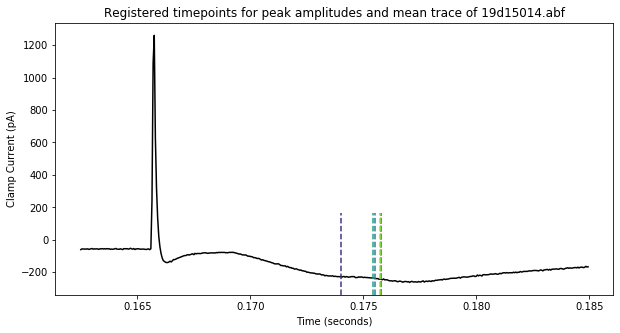

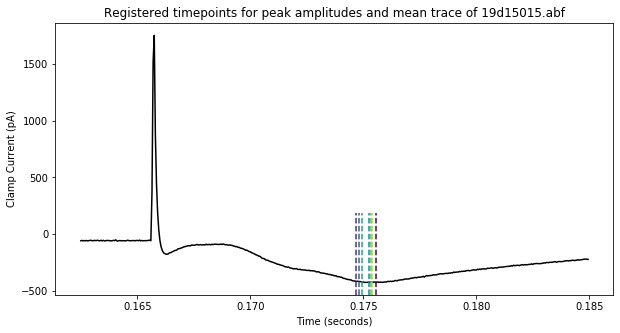

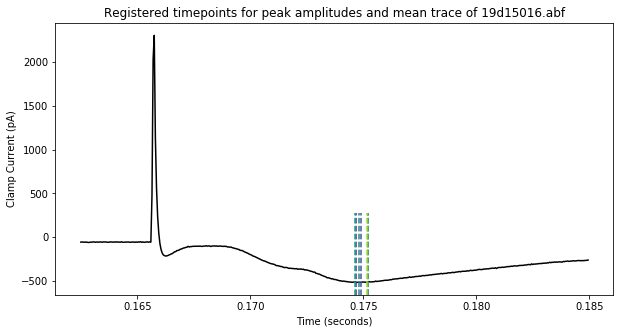

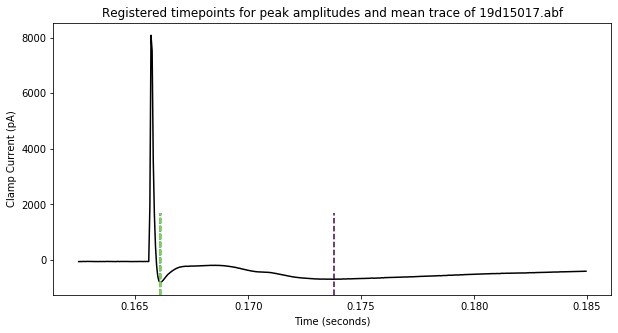

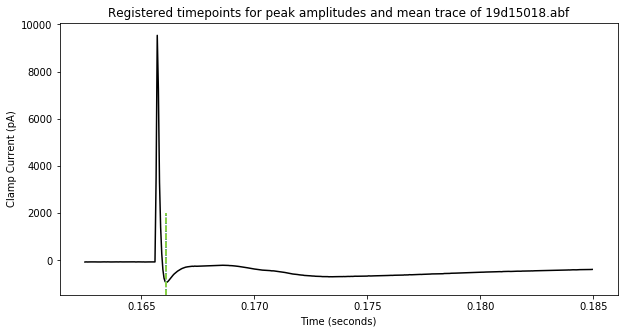

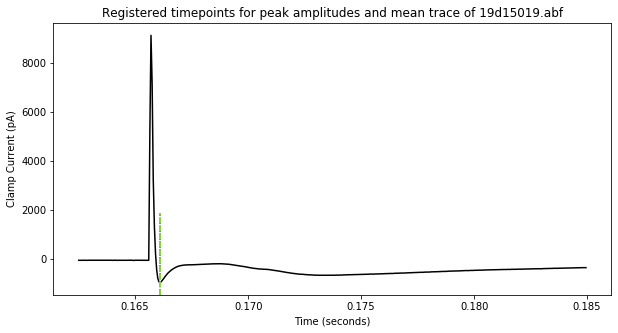

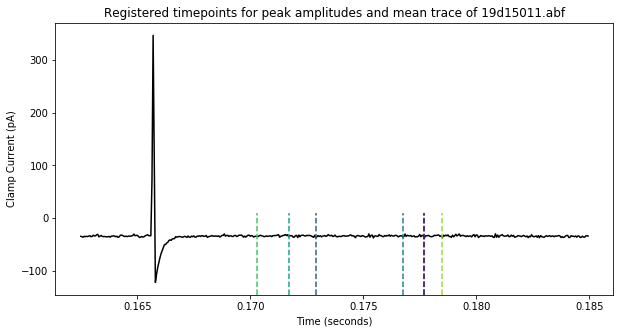

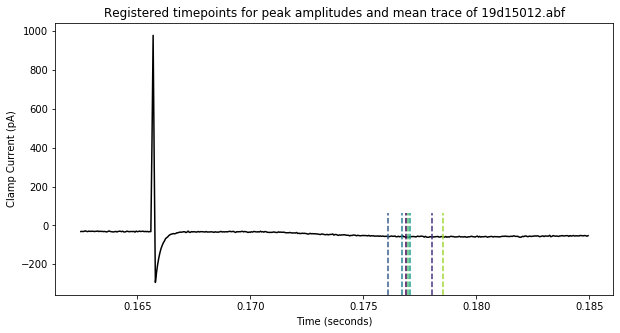

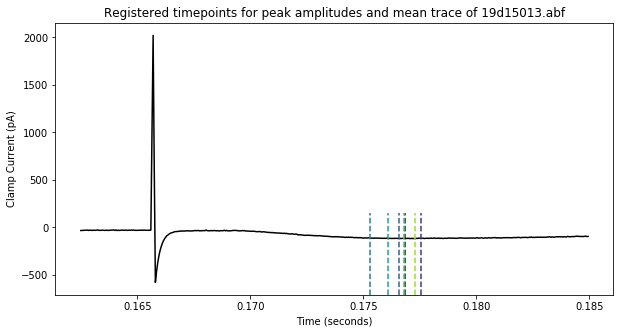

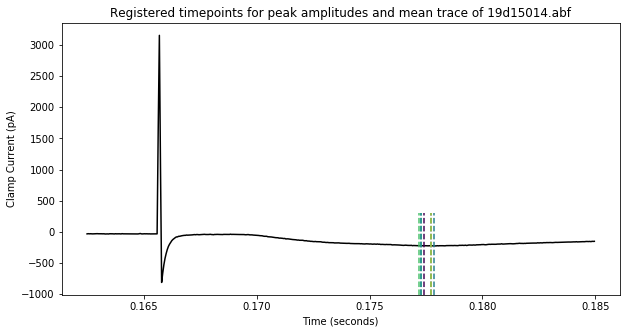

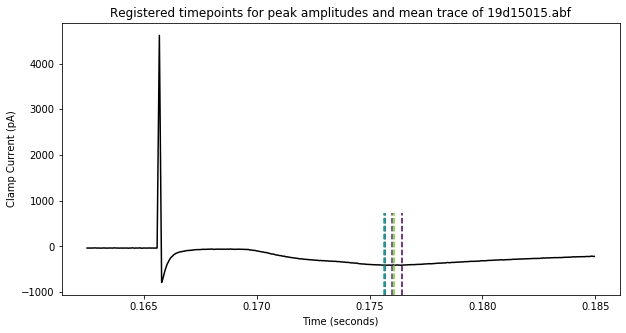

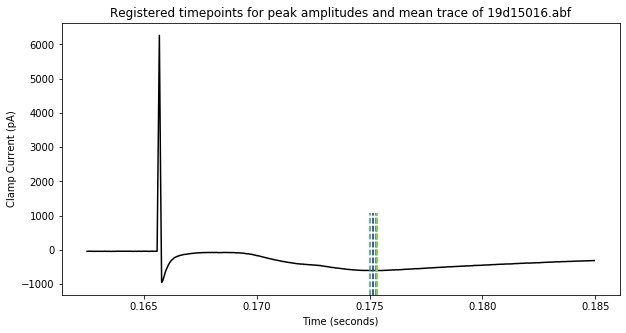

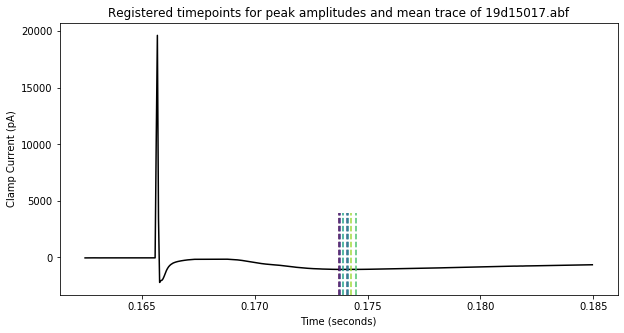

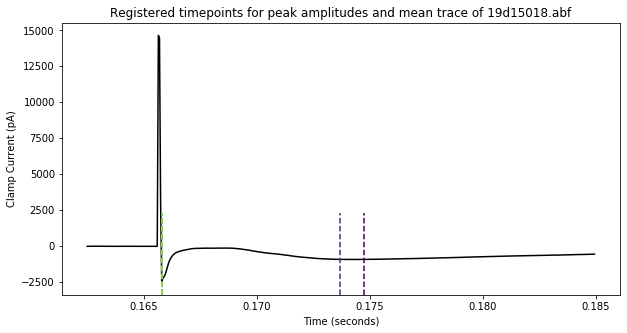

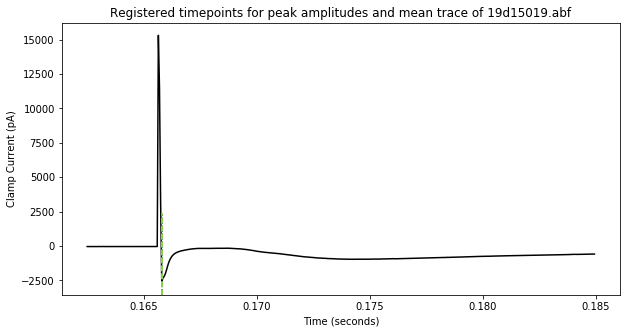

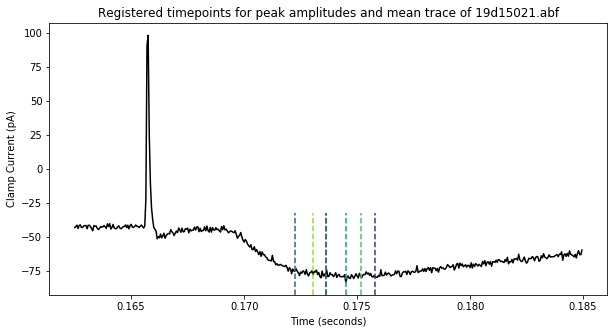

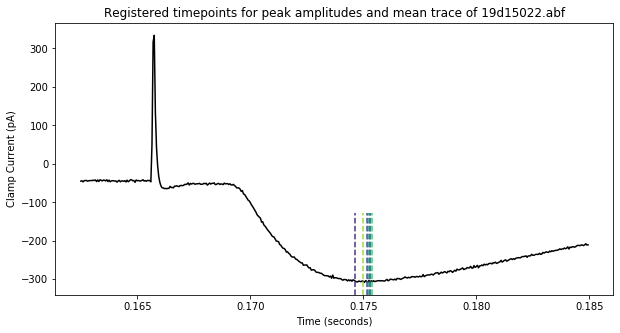

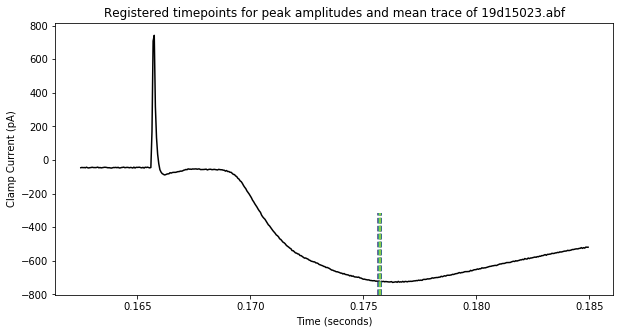

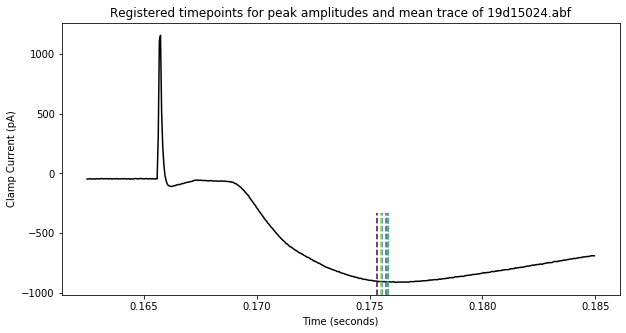

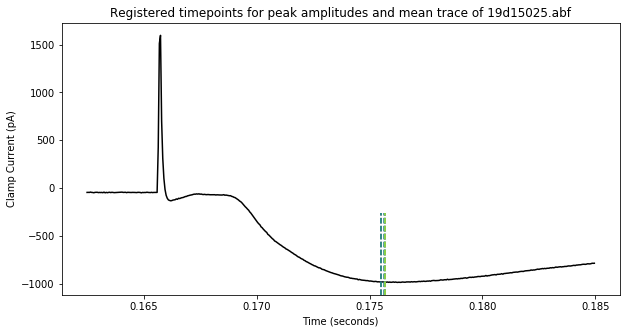

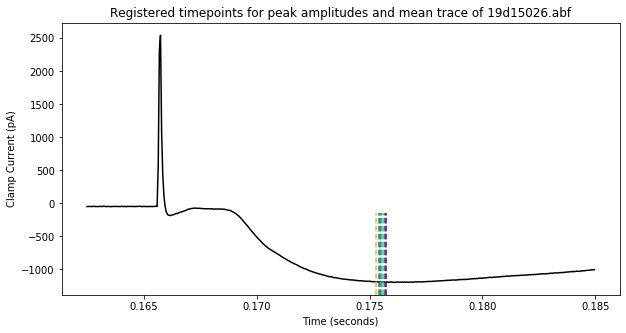

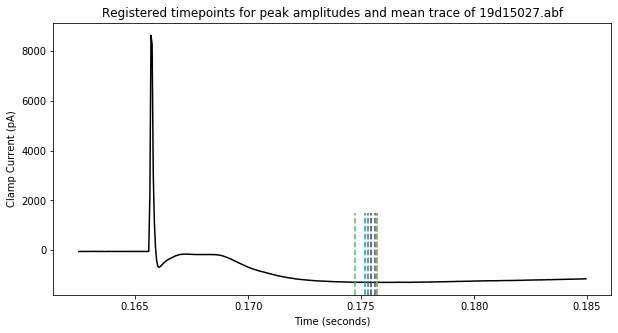

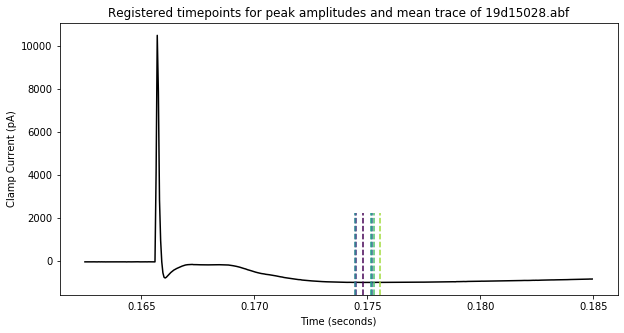

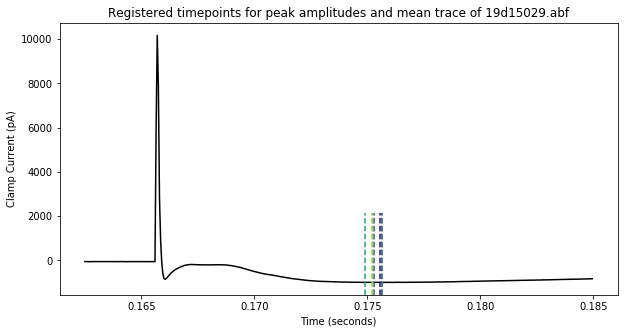

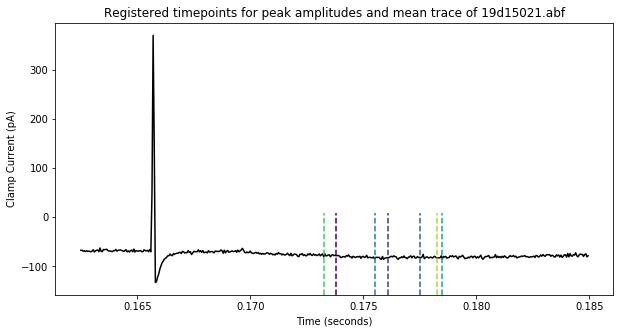

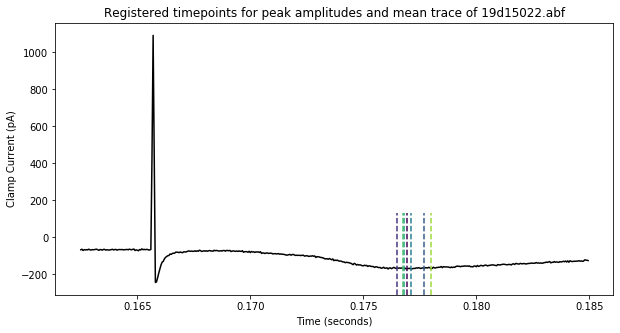

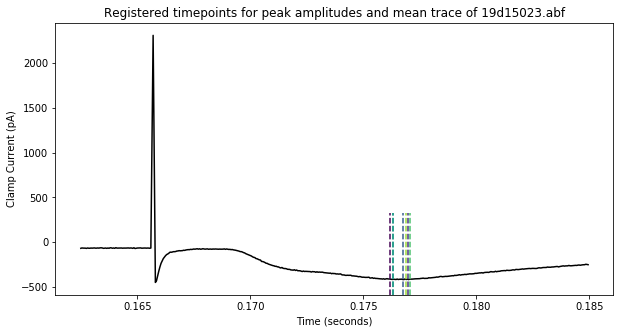

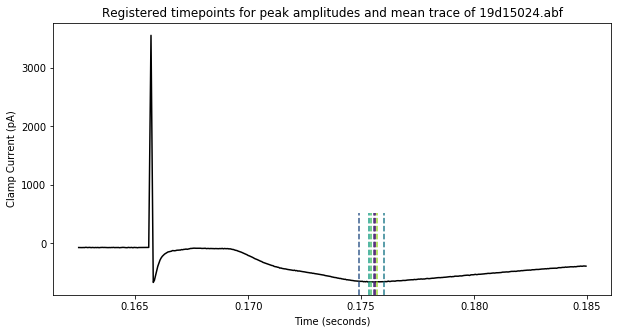

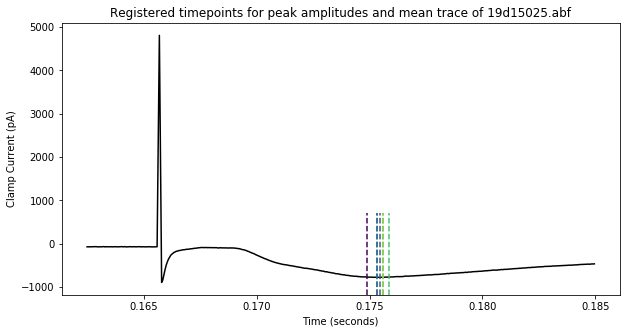

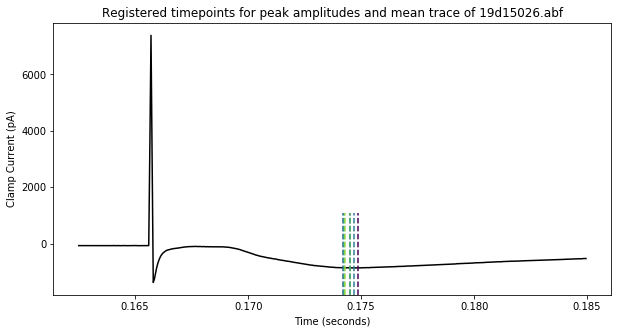

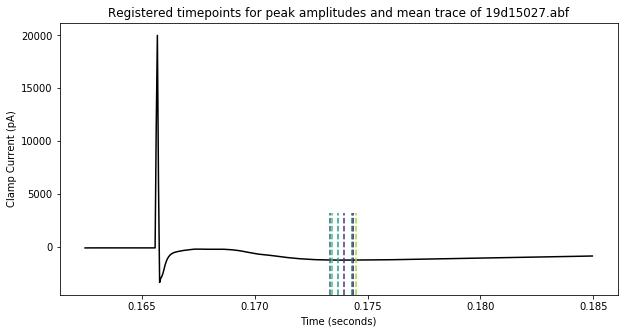

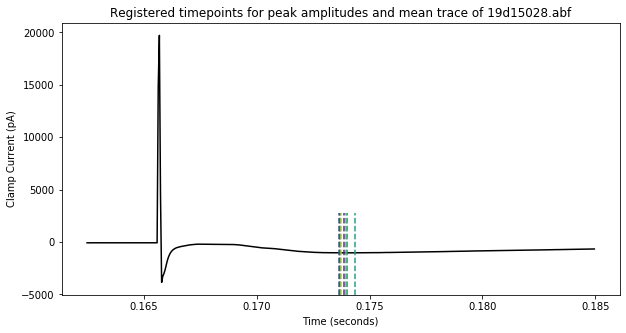

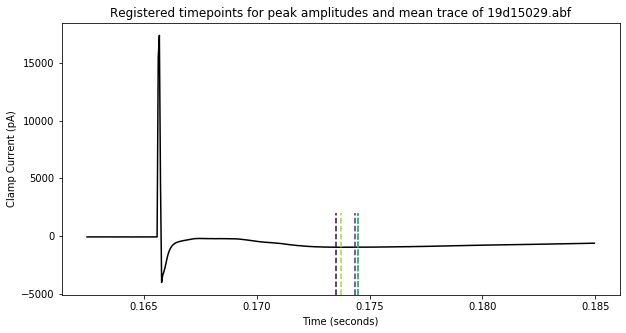

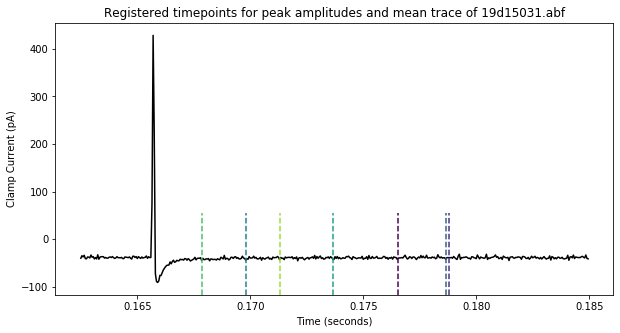

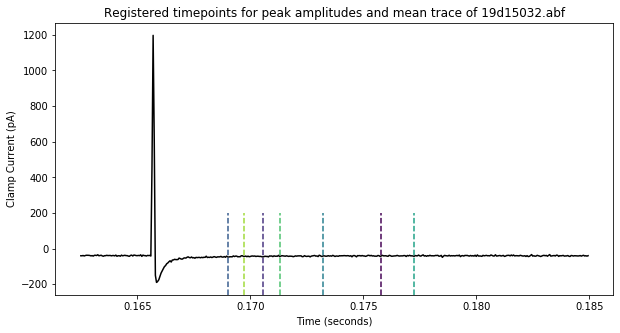

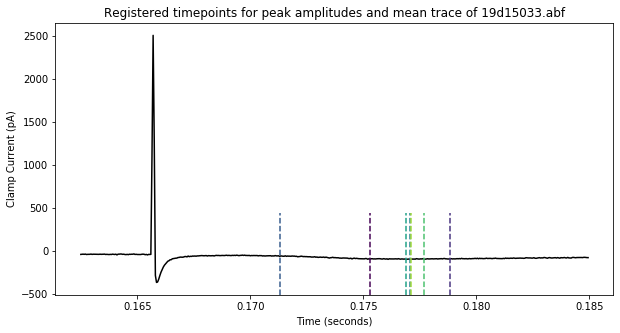

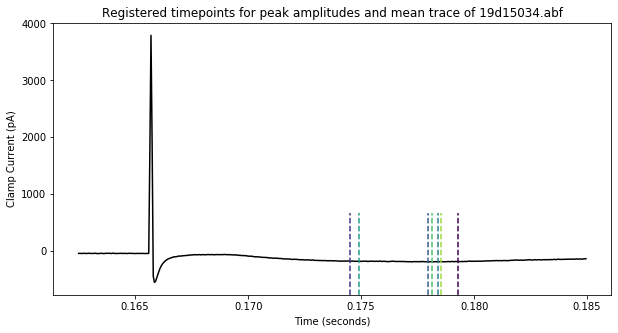

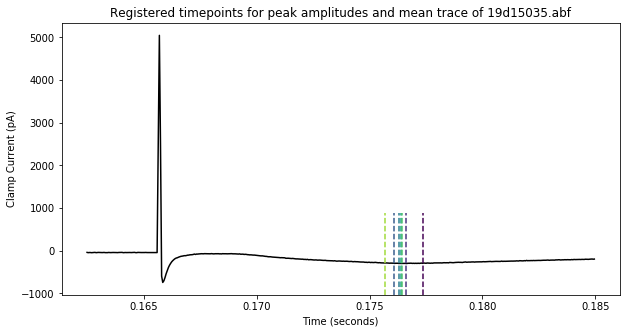

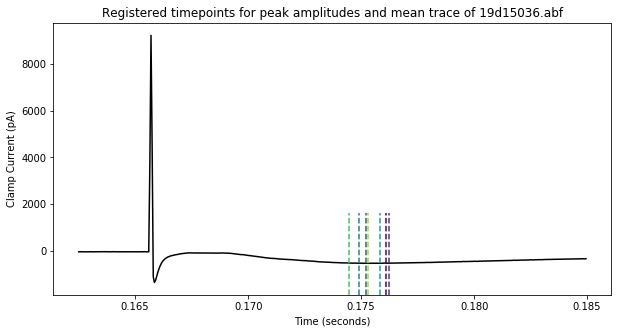

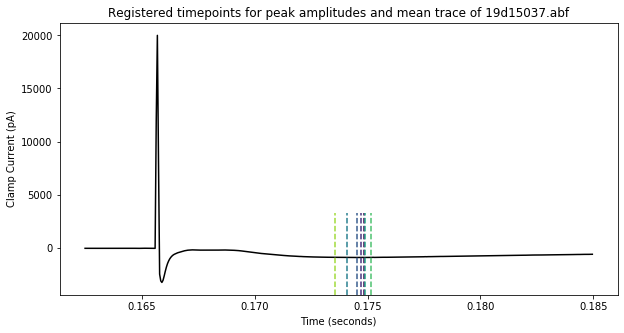

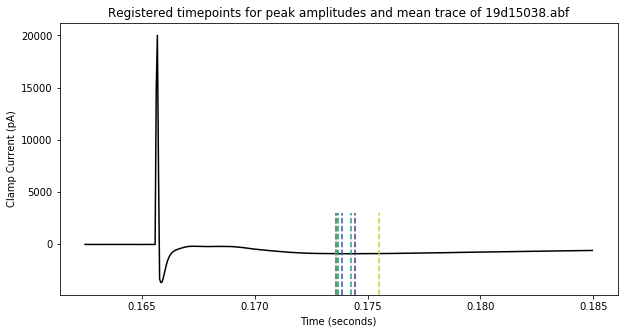

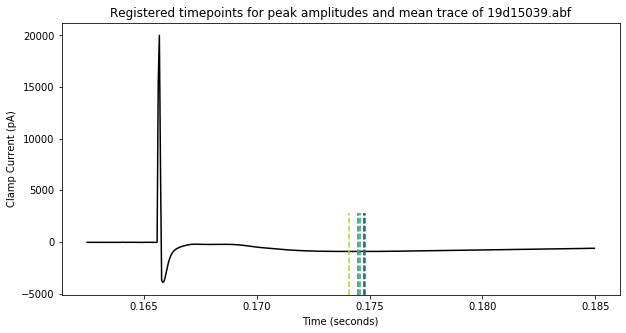

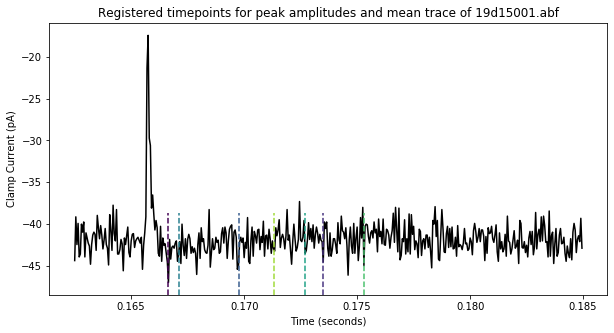

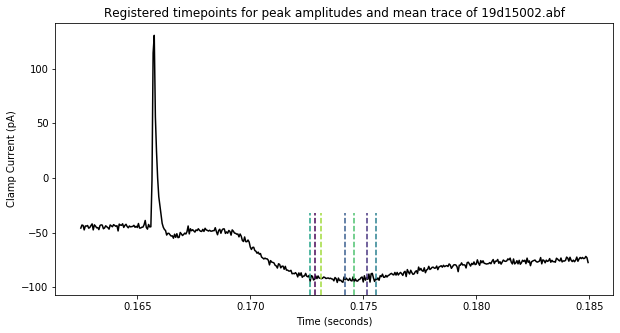

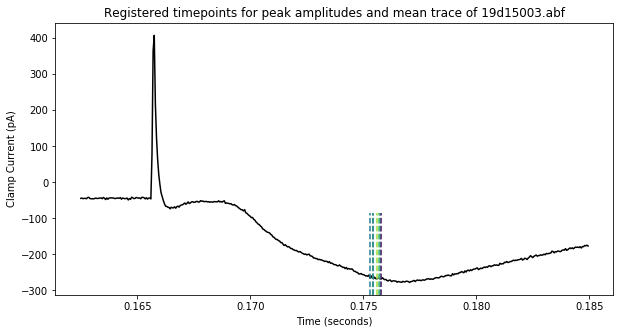

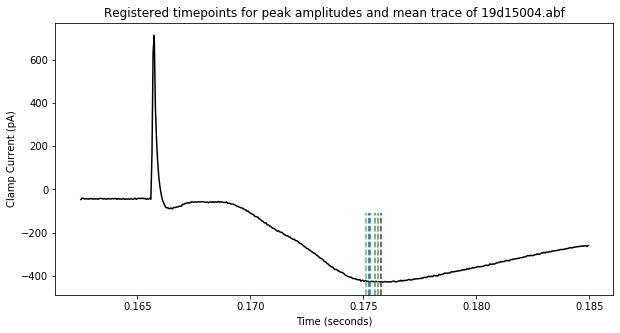

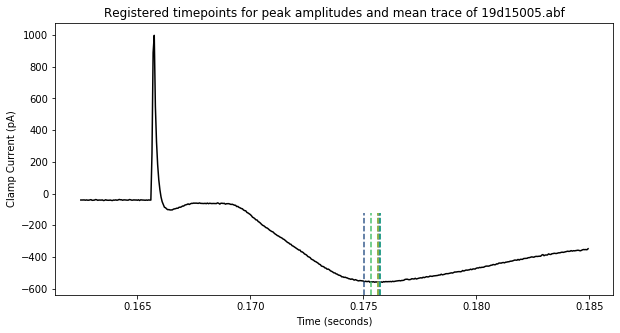

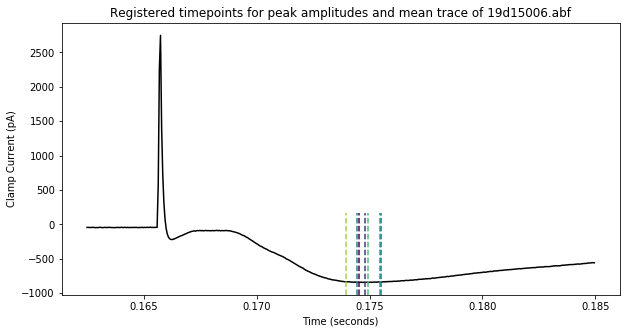

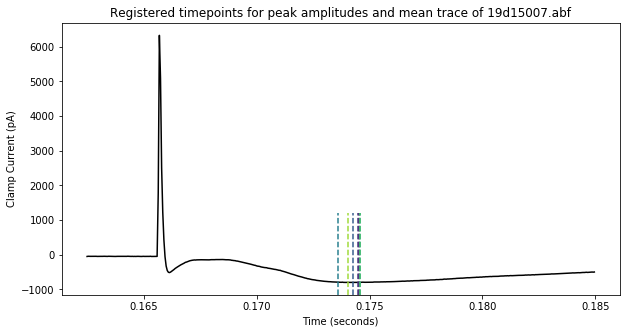

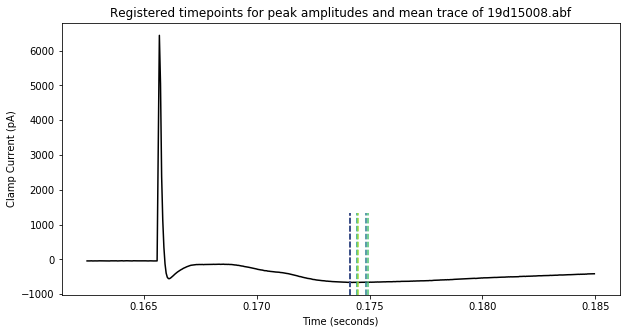

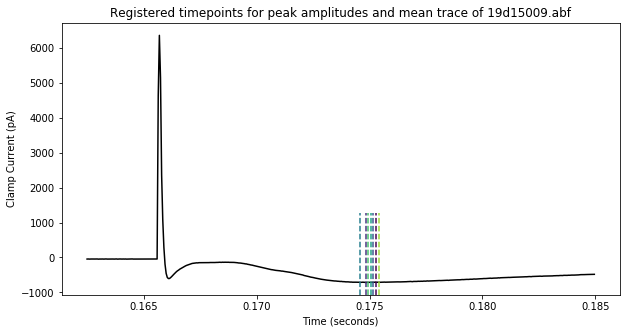

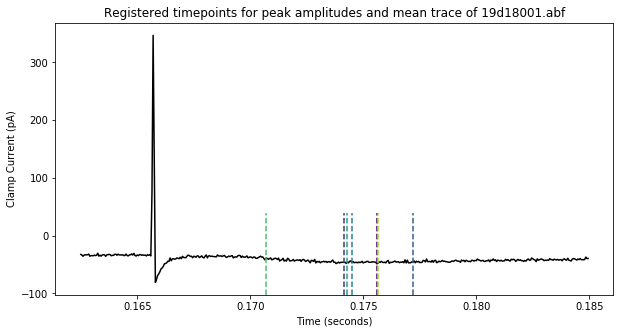

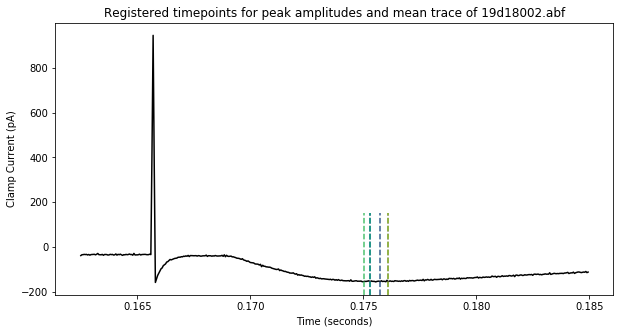

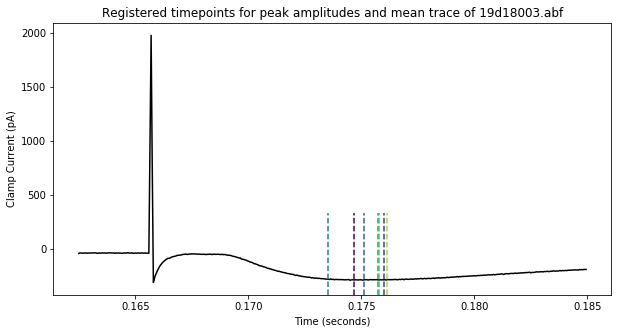

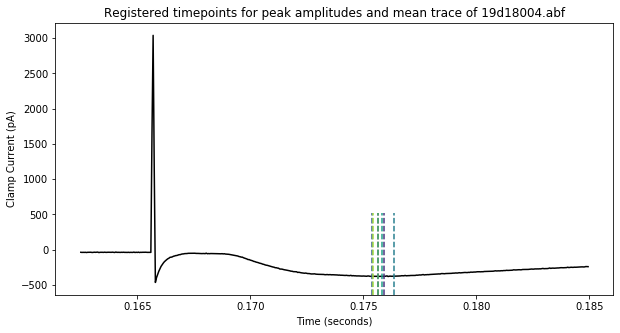

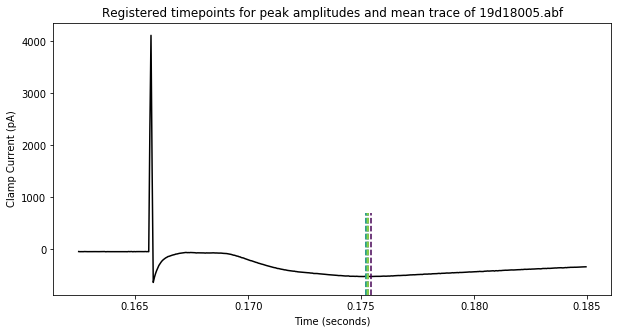

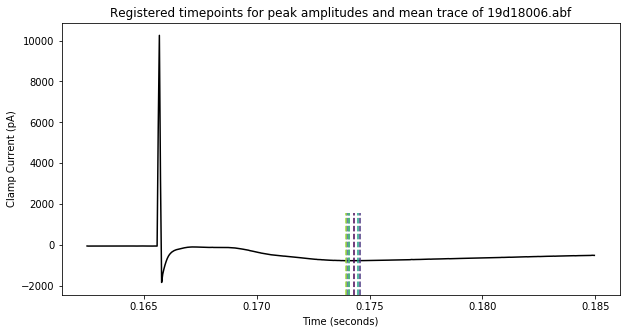

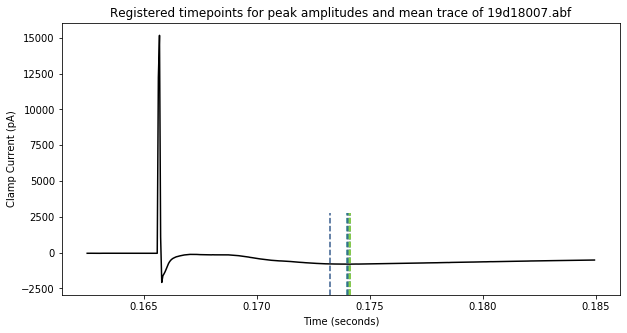

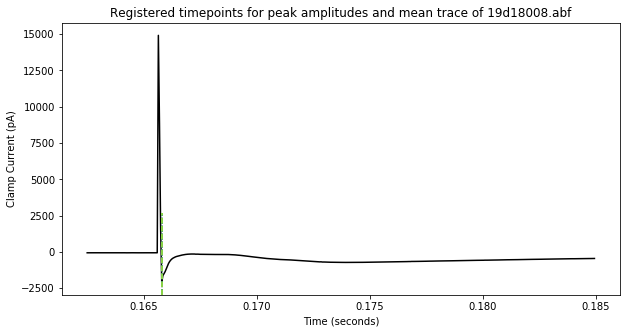

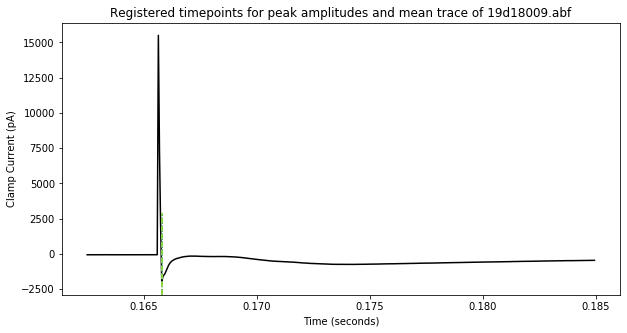

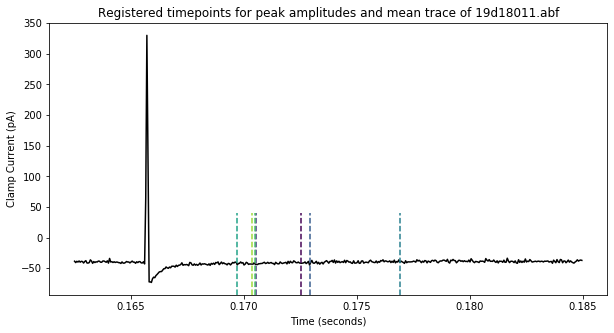

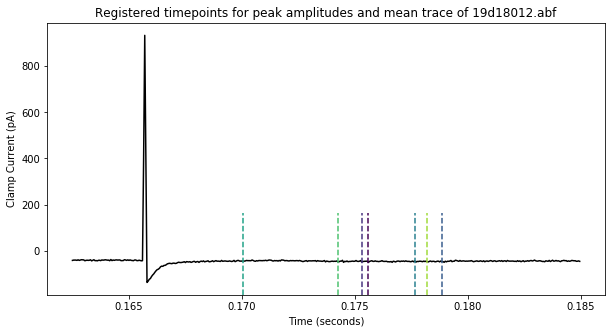

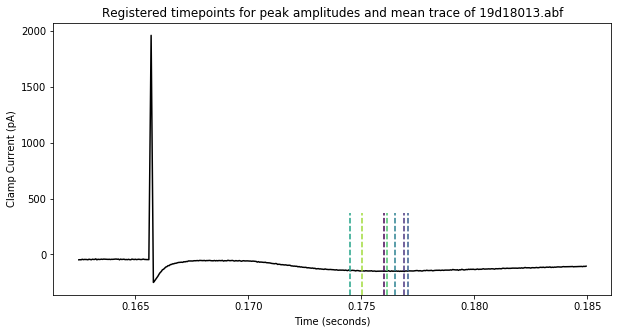

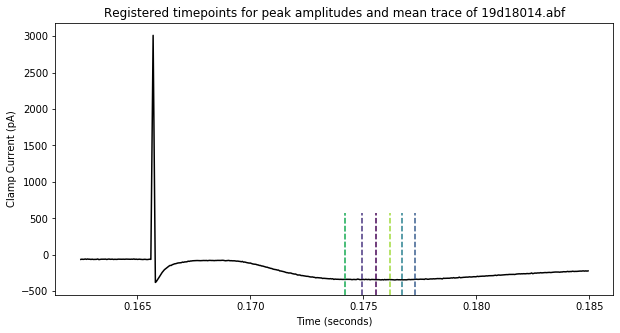

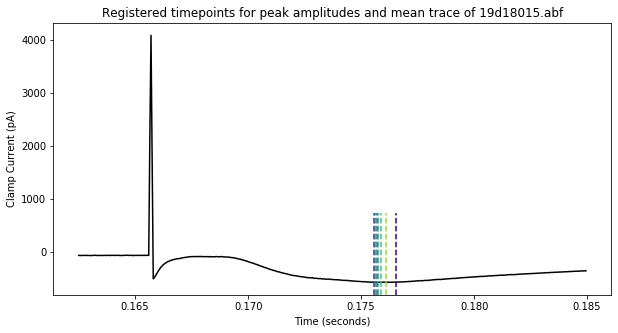

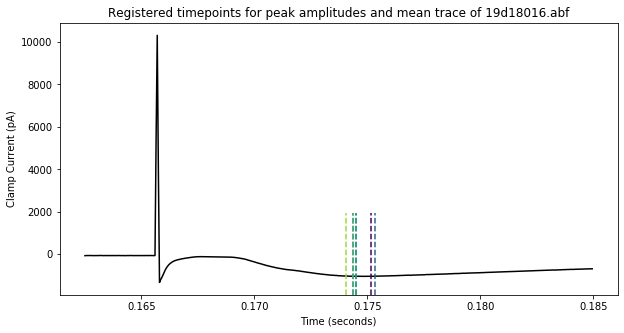

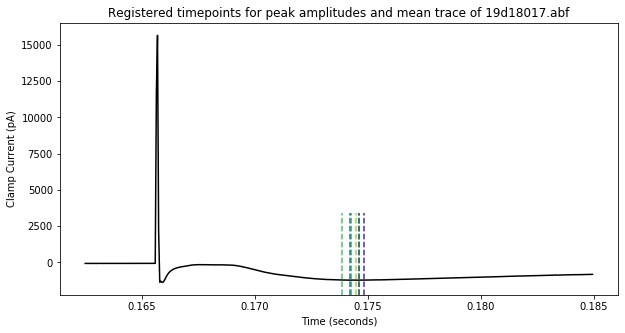

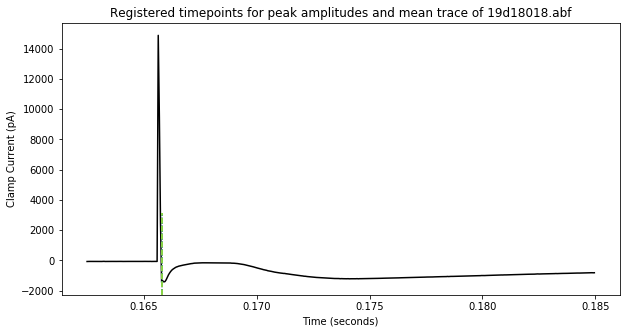

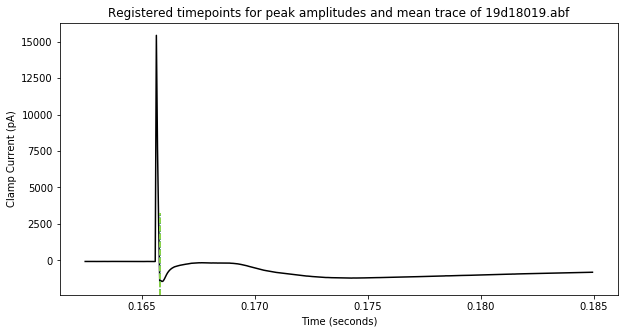

In [249]:

path = askdirectory(title='Select Folder with all data from one experiment') # shows dialog box and return the path 
os.chdir(path)

if os.path.exists('.DS_Store') == True: #external drive issue with Adrian's computer, shouldn't hurt anything
    os.remove('.DS_Store')          
gen_dir = os.getcwd()
mouse_folders = os.listdir('.')

# Go to each folder in dataset that corresponds to one mouse
for mouse in mouse_folders:
    
    mouse_dir = gen_dir + '/' + mouse # get directory for one mouse
    os.chdir(mouse_dir)  #change directory to that mouse
    if os.path.exists('.DS_Store') == True: # external drive again
        os.remove('.DS_Store')    
    mouse_wd = os.getcwd() 
    cell_folders = os.listdir(mouse_wd) # list the cells (directories) of that mouse
    
# Go to each subfolder that corresponds to each cell of one mouse    
    for cell in cell_folders:
        if cell == '.DS_Store':
            os.remove('.DS_Store')    
        
        elif 'cell' in cell and 'processed' not in cell:
            processed_file = cell + '_processed'
            processed_dir = mouse_wd + '/' + processed_file
            if not os.path.exists(processed_dir):
                os.mkdir(processed_dir)
            cell_dir = mouse_dir + '/' + cell
            os.chdir(cell_dir)# change directory to one cell of one mouse
            cell_wd = os.getcwd()
            if os.path.exists('.DS_Store') == True: # external drive again
                os.remove('.DS_Store')       
            
# Create metadata in case its not there already            
            contents = os.listdir(cell_wd) # list all contents of this cell
            all_header_files = get_txt_metadata(mouse,contents) 
            all_csv_files = get_csv_metadata(all_header_files)
            
# KEY STEP - get metadata from experiment excel files (from lab notes)            
            new_contents = os.listdir('.')
            stim_int, cellnum, validated_ABFs = get_xlxs_data(mouse,new_contents)
            validated_CSVs = df_prep_v2(mouse,validated_ABFs,new_contents)
            
# Generate dataframes and save onto _processed folder in mouse directory, one per each cell (could be 2 per cell folder)
            cell_channels = [*range(cellnum)]
            for ch in cell_channels:
                channel_ind = ch*2
                cell_ID = ch + 1
                #print(validated_ABFs)
                #print(validated_CSVs)
                #print(stim_int)
                summary, all_peak_times, fig = data_summary_percell_v2(channel_ind, validated_ABFs, 
                                                                  validated_CSVs, stim_int)
                
                summ_path = processed_dir + '/' + cell + '_' + str(cell_ID) + '_summary.csv'
                tp_path = processed_dir + '/'  + cell + '_' + str(cell_ID) + '_timepoints.csv'
                plot_path = processed_dir + '/'  + cell + '_' + str(cell_ID) + '_plot'
                
                summary.to_csv(summ_path, index = True)
                all_peak_times.to_csv(tp_path, index = True)
                plt.savefig(plot_path)
   
  

Adaptation of `data_summary_percell` so far:

1. Input `cellnum`. If 1, proceed exactly as it is written in the original function and return dataframes of 1 cell. If 2, run everything twice, once for `abf.sweepY` and once for the other cell trace and return dataframes for each cell. 
2. Instead of manually typing in `cellnum` in each excel file (which is okay but might not be convenient if there's much more data down the line, we can use `nADCNum` from the metadata csv to find out how many channels there are per sweep: if 2, then its only one cell, if 4, 2 cells, and so forth. 
2. Save all dataframes in that same folder for consistency, but if `cellnum` = 2, then write each one with a different name to avoid confounds, they are still technically 2 different datapoints. 